In [3]:
import os
import re
import json
import time
import string
import warnings
from collections import Counter
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import umap
import hdbscan

In [4]:
processing = pd.read_csv('combined_posts_processing.csv')
cinder = pd.read_csv('combined_posts_cinder.csv')

post_dir = Path('./test_archive_openrndr/posts')
openrndr = []

for json_file in post_dir.glob('**/*.json'):
    with open(json_file, 'r') as f:
        post_data = json.load(f)
        openrndr.append(post_data)

openrndr = pd.DataFrame(openrndr)

/var/folders/g5/d9_b48zx673cq3r2_9nwfb4m0000gn/T/ipykernel_63578/3425754719.py:1: DtypeWarning: Columns (51,63,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  processing = pd.read_csv('combined_posts_processing.csv')


In [5]:
columns_processing = set(processing.columns)
columns_cinder = set(cinder.columns)
columns_openrndr = set(openrndr.columns)

common_columns_pc = columns_processing.intersection(columns_cinder)
common_columns_po = columns_processing.intersection(columns_openrndr)

unique_to_processingc = columns_processing - columns_cinder
unique_to_cinder = columns_cinder - columns_processing

unique_to_processingo = columns_processing - columns_openrndr
unique_to_openrndr = columns_openrndr - columns_processing

In [6]:
# with cinder
print("columns in common (processing x cinder):\n", common_columns_pc)
print("\ncolumns only in processing:\n", unique_to_processingc)
print("\ncolumns only in cinder:\n", unique_to_cinder)

columns in common (processing x cinder):
 {'created_at', 'can_accept_answer', 'score', 'reply_to_user', 'moderator', 'reads', 'reply_to_post_number', 'topic_id', 'topic_accepted_answer', 'can_recover', 'can_see_hidden_post', 'primary_group_name', 'wiki', 'display_username', 'title_is_group', 'edit_reason', 'bookmarked', 'staff', 'reply_count', 'quote_count', 'avatar_template', 'flair_url', 'read', 'updated_at', 'cooked', 'name', 'flair_name', 'admin', 'flair_bg_color', 'user_id', 'topic_slug', 'polls', 'post_number', 'deleted_at', 'link_counts', 'flair_color', 'username', 'can_view_edit_history', 'can_unaccept_answer', 'can_wiki', 'can_edit', 'user_title', 'hidden', 'flair_group_id', 'can_delete', 'id', 'incoming_link_count', 'readers_count', 'via_email', 'trust_level', 'user_deleted', 'yours', 'actions_summary', 'accepted_answer', 'version', 'post_type'}

columns only in processing:
 {'reviewable_id', 'user_cakedate', 'user_suspended', 'hidden_reason_id', 'akismet_state', 'user_birthd

In [7]:
# with openrndr
print("columns in common (processing x openrndr):\n", common_columns_po)
print("\ncolumns only in processing:\n", unique_to_processingc)
print("\ncolumns only in openrndr:\n", unique_to_openrndr)

columns in common (processing x openrndr):
 {'created_at', 'can_accept_answer', 'score', 'reply_to_user', 'moderator', 'reads', 'reply_to_post_number', 'topic_id', 'topic_accepted_answer', 'can_recover', 'can_see_hidden_post', 'primary_group_name', 'wiki', 'display_username', 'edit_reason', 'bookmarked', 'staff', 'reply_count', 'quote_count', 'avatar_template', 'flair_url', 'updated_at', 'cooked', 'name', 'flair_name', 'admin', 'flair_bg_color', 'user_id', 'topic_slug', 'polls', 'post_number', 'deleted_at', 'flair_color', 'username', 'can_view_edit_history', 'can_unaccept_answer', 'can_wiki', 'can_edit', 'user_title', 'hidden', 'flair_group_id', 'can_delete', 'id', 'incoming_link_count', 'readers_count', 'via_email', 'trust_level', 'user_deleted', 'yours', 'actions_summary', 'accepted_answer', 'version', 'post_type'}

columns only in processing:
 {'reviewable_id', 'user_cakedate', 'user_suspended', 'hidden_reason_id', 'akismet_state', 'user_birthdate', 'locked', 'action_code', 'reviewa

In [8]:
df_processing = processing[['id', 'created_at', 'cooked', 'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id']].copy()
df_cinder = cinder[['id', 'created_at', 'cooked', 'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id']].copy()
df_openrndr = openrndr[['id', 'created_at', 'cooked', 'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id']].copy()

In [9]:
df_processing['created_at'] = pd.to_datetime(df_processing['created_at'])
df_cinder['created_at'] = pd.to_datetime(df_cinder['created_at'])
df_openrndr['created_at'] = pd.to_datetime(df_openrndr['created_at'])

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

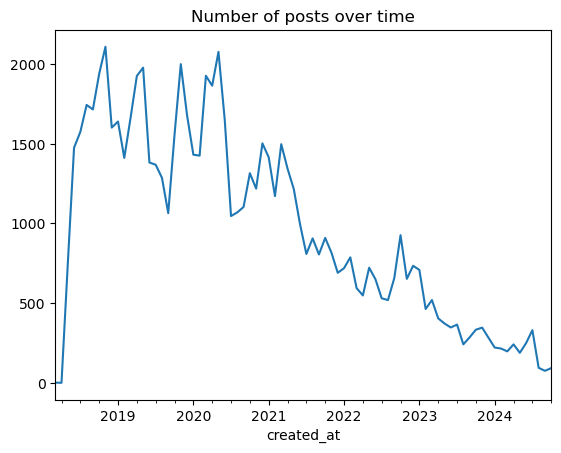

In [117]:
df_processing.set_index('created_at').resample('M').size().plot(title='Number of posts over time')

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

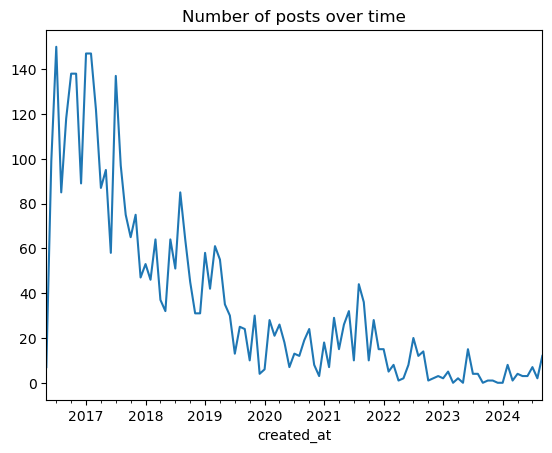

In [118]:
df_cinder.set_index('created_at').resample('M').size().plot(title='Number of posts over time')

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

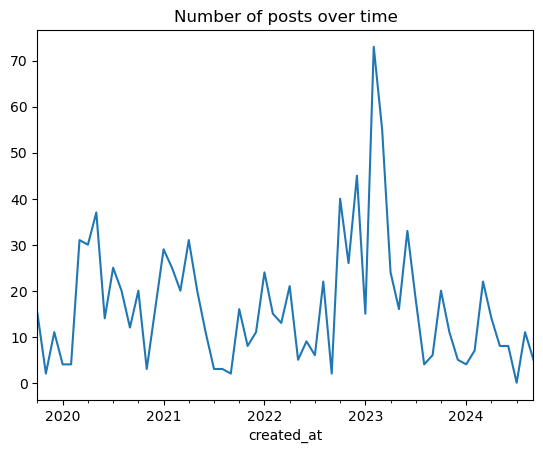

In [119]:
df_openrndr.set_index('created_at').resample('M').size().plot(title='Number of posts over time')

In [11]:
df_processing['year'] = df_processing['created_at'].dt.year
df_cinder['year'] = df_cinder['created_at'].dt.year
df_openrndr['year'] = df_openrndr['created_at'].dt.year

### cleaning and inspection of text data

In [12]:
print(
    f"The length of the Processing dataset is {df_processing.shape[0]}\n"
    f"Records range from {df_processing['year'].min()} to {df_processing['year'].max()}\n\n"
    f"The length of the Cinder dataset is {df_cinder.shape[0]}\n"
    f"Records range from {df_cinder['year'].min()} to {df_cinder['year'].max()}\n\n"
    f"The length of the OpenRNDR dataset is {df_openrndr.shape[0]}\n"
    f"Records range from {df_openrndr['year'].min()} to {df_openrndr['year'].max()}\n\n"
)

The length of the Processing dataset is 95481
Records range from 2018 to 2024

The length of the Cinder dataset is 4461
Records range from 2016 to 2024

The length of the OpenRNDR dataset is 1255
Records range from 2019 to 2024




In [13]:
df_processing['cooked'] = df_processing['cooked'].fillna('')
#df_cinder['cooked'] = df_cinder['cooked'].fillna('')
#df_openrndr['cooked'] = df_openrndr['cooked'].fillna('')

In [225]:
# Function to find all tags in a single post
def find_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return [tag.name for tag in soup.find_all()]

#all_tags_processing = processing['cooked'].apply(find_tags).sum()
#tag_counts_processing = Counter(all_tags_processing)
#print("Unique HTML tags present and their counts:")
#print(tag_counts_processing)

In [229]:
Counter(df_processing['cooked'].apply(find_tags).sum())

Counter({'p': 201677,
         'br': 61244,
         'pre': 29108,
         'code': 54696,
         'em': 5091,
         'strong': 7238,
         'aside': 15658,
         'header': 5041,
         'img': 37562,
         'a': 50706,
         'article': 5045,
         'h3': 4035,
         'div': 45563,
         'svg': 10628,
         'use': 10458,
         'span': 15964,
         'blockquote': 12865,
         'ul': 3461,
         'li': 14050,
         'h4': 1094,
         'h5': 358,
         'hr': 1249,
         'h1': 63,
         'ol': 1373,
         'iframe': 314,
         'h2': 193,
         'details': 529,
         'summary': 529,
         'kbd': 158,
         'path': 170,
         'table': 14,
         'thead': 14,
         'tr': 89,
         'th': 47,
         'tbody': 14,
         'td': 234,
         'strike': 15,
         'i': 3,
         'b': 16,
         's': 35,
         'small': 5,
         'del': 33,
         'video': 17,
         'source': 20,
         'ins': 1,
         'su

In [14]:
# Function to extract content of specific tages
def extract_tag_content(row):
    soup = BeautifulSoup(row, "html.parser")

    code_content = " ".join([tag.get_text() for tag in soup.find_all('code')])
    a_content = " ".join([tag.get_text() for tag in soup.find_all('a')])
    #iframe_content = " ".join([tag.get_text() for tag in soup.find_all('iframe')])

    return pd.Series({
        'code_content': code_content,
        'a_content': a_content,
        #'iframe_content': iframe_content
    })

In [15]:
df_processing[['code_content', 'a_content']] = df_processing['cooked'].apply(extract_tag_content)
df_cinder[['code_content', 'a_content']] = df_cinder['cooked'].apply(extract_tag_content)
df_openrndr[['code_content', 'a_content']] = df_openrndr['cooked'].apply(extract_tag_content)

In [16]:
# Function to remove content of certain tags
def clean_cooked_tag_content(row):
    soup = BeautifulSoup(row, "html.parser")
    for tag in soup.find_all(['code', 'a', 'iframe', 'img', 'svg', 'source', 'video', 'track', 'sub']):
        tag.decompose()
    
    return str(soup)

In [17]:
df_processing['cooked_cleaned'] = df_processing['cooked'].apply(clean_cooked_tag_content)
df_cinder['cooked_cleaned'] = df_cinder['cooked'].apply(clean_cooked_tag_content)
df_openrndr['cooked_cleaned'] = df_openrndr['cooked'].apply(clean_cooked_tag_content)

In [18]:
# Function to clean HTML tags
def clean_html_tags(text):
    # Parse the HTML content
    soup = BeautifulSoup(text, "html.parser")
    # Get plain text without HTML tags
    clean_text = soup.get_text()
    # Remove extra whitespace, newline characters, etc.
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

In [19]:
df_processing['cooked_html_cleaned'] = df_processing['cooked_cleaned'].apply(clean_html_tags)
df_cinder['cooked_html_cleaned'] = df_cinder['cooked_cleaned'].apply(clean_html_tags)
df_openrndr['cooked_html_cleaned'] = df_openrndr['cooked_cleaned'].apply(clean_html_tags)

#### word count

In [20]:
df_processing['word_count'] = df_processing['cooked_html_cleaned'].str.split().str.len()
df_cinder['word_count'] = df_cinder['cooked_html_cleaned'].str.split().str.len()
df_openrndr['word_count'] = df_openrndr['cooked_html_cleaned'].str.split().str.len()

In [21]:
df_processing['word_count'].describe()

count    95481.000000
mean        62.162252
std         76.235249
min          0.000000
25%         19.000000
50%         42.000000
75%         80.000000
max       5633.000000
Name: word_count, dtype: float64

In [22]:
df_cinder['word_count'].describe()

count    4461.000000
mean       79.287380
std        84.689376
min         0.000000
25%        27.000000
50%        56.000000
75%       104.000000
max      1953.000000
Name: word_count, dtype: float64

In [23]:
df_openrndr['word_count'].describe()

count    1255.000000
mean       67.179283
std        78.062200
min         0.000000
25%        21.500000
50%        45.000000
75%        87.000000
max      1196.000000
Name: word_count, dtype: float64

In [24]:
# initially was 5%, we're now trying 10%
print(f'Processing data lower threshold (bottom 10%): {df_processing["word_count"].quantile(0.1)}\n')
print(f'Processing data upper threshold (top 10%): {df_processing["word_count"].quantile(0.9)}\n\n')

print(f'Cinder data lower threshold (bottom 10%): {df_cinder["word_count"].quantile(0.1)}\n')
print(f'Cinder data upper threshold (top 10%): {df_cinder["word_count"].quantile(0.9)}\n\n')

print(f'OpenRNDR data lower threshold (bottom 10%): {df_openrndr["word_count"].quantile(0.1)}\n')
print(f'OpenRNDR data upper threshold (top 10%): {df_openrndr["word_count"].quantile(0.9)}')

Processing data lower threshold (bottom 10%): 9.0

Processing data upper threshold (top 10%): 135.0


Cinder data lower threshold (bottom 10%): 13.0

Cinder data upper threshold (top 10%): 173.0


OpenRNDR data lower threshold (bottom 10%): 10.0

OpenRNDR data upper threshold (top 10%): 147.60000000000014


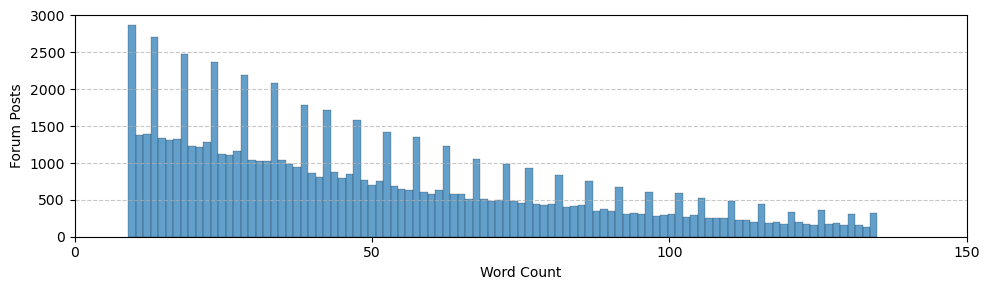

In [25]:
# Calculate and filter word count
df_processing['word_count'] = df_processing['cooked_html_cleaned'].str.split().str.len()
df_processing = df_processing[df_processing['word_count'].between(9, 135)] # filters to include word count only from length ... to ...

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(df_processing['word_count'], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel('Word Count')
plt.ylabel('Forum Posts')
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks at every 200 units
plt.xticks(range(0, df_processing['word_count'].max() + 50, 50))

plt.tight_layout()
plt.show()

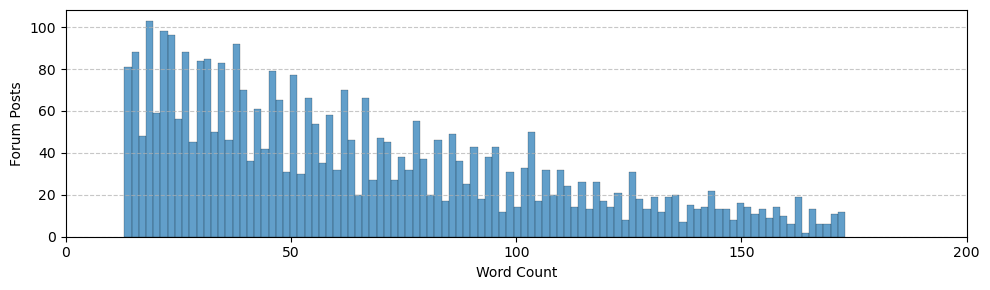

In [26]:
# Calculate and filter word count
df_cinder['word_count'] = df_cinder['cooked_html_cleaned'].str.split().str.len()
df_cinder = df_cinder[df_cinder['word_count'].between(13, 173)] # filters to include word count only from length ... to ...

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(df_cinder['word_count'], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel('Word Count')
plt.ylabel('Forum Posts')
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks at every 200 units
plt.xticks(range(0, df_cinder['word_count'].max() + 50, 50))

plt.tight_layout()
plt.show()

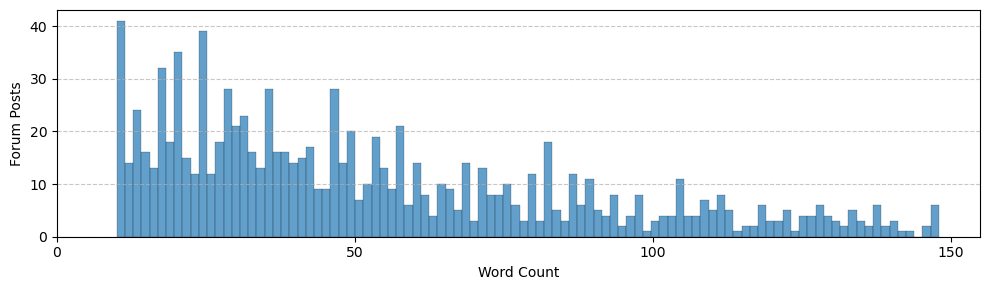

In [27]:
# Calculate and filter word count
df_openrndr['word_count'] = df_openrndr['cooked_html_cleaned'].str.split().str.len()
df_openrndr = df_openrndr[df_openrndr['word_count'].between(10, 148)] # filters to include word count only from length ... to ...

# Plot histogram
plt.figure(figsize=(10, 3))
plt.hist(df_openrndr['word_count'], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel('Word Count')
plt.ylabel('Forum Posts')
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set x-axis ticks at every 200 units
plt.xticks(range(0, df_openrndr['word_count'].max() + 50, 50))

plt.tight_layout()
plt.show()

In [28]:
# maybe before parsing, combine topic slug with the actual text of the forum post
df_processing['combined'] = df_processing['topic_slug'].str.replace('-', ' ', regex=False) + ' ' + df_processing['cooked_html_cleaned']
df_cinder['combined'] = df_cinder['topic_slug'].str.replace('-', ' ', regex=False) + ' ' + df_cinder['cooked_html_cleaned']
df_openrndr['combined'] = df_openrndr['topic_slug'].str.replace('-', ' ', regex=False) + ' ' + df_openrndr['cooked_html_cleaned']

#### parsing
Parsing in this context refers to syntactic analysis of the text. When spaCy processes text, it `Tokenizes`, `Tags`, `Analyzes Dependencies`, `Identifies Named Entities`

In [30]:
# loading spacy model
nlp = spacy.load("en_core_web_sm") # small model

# enabling tqdm for pandas -> progress bar
tqdm.pandas()

In [31]:
df_processing['parsing'] = df_processing['cooked_html_cleaned'].progress_apply(nlp)
df_cinder['parsing'] = df_cinder['cooked_html_cleaned'].progress_apply(nlp)
df_openrndr['parsing'] = df_openrndr['cooked_html_cleaned'].progress_apply(nlp)

100%|██████████| 1010/1010 [00:09<00:00, 101.72it/s]


#### inspecting current most frequent words

In [32]:
def get_most_common_lemmas(df, column_name, top_n=20):

    # flattening all lemmas into a single list
    all_lemmas = list(itertools.chain.from_iterable(
        [token.lemma_.lower() for token in doc if token.is_alpha] for doc in df[column_name]
    ))

    # Count lemma frequencies
    lemma_counts = Counter(all_lemmas)

    # Return the most common lemmas
    return lemma_counts.most_common(top_n)

In [33]:
top_lemmas_processing = get_most_common_lemmas(df_processing, column_name='parsing', top_n=20)
top_lemmas_processing

[('the', 199911),
 ('i', 142569),
 ('be', 133131),
 ('to', 125176),
 ('a', 88972),
 ('you', 74430),
 ('and', 72710),
 ('it', 71558),
 ('in', 53771),
 ('of', 48996),
 ('that', 45215),
 ('do', 44924),
 ('for', 43321),
 ('this', 41739),
 ('have', 37274),
 ('use', 32871),
 ('with', 31804),
 ('but', 30587),
 ('can', 30410),
 ('code', 29066)]

#### tokenization, lemmatization

In [34]:
# defining custom stop words
CUSTOM_STOP_WORDS_P = set() # empty
CUSTOM_STOP_WORDS_C = set()
CUSTOM_STOP_WORDS_O = set()

# cleaning tokens
def clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_P):
    return [
        token.lemma_.lower().strip() # take the lemma (base form), lowercase, remove extra spaces
        for token in text
        if token.pos_ in {'PROPN', 'NOUN'} # keeping only proper nouns and common nouns, based on POS tags
        and token.is_alpha # excluding tokens with non-alphabetic characters (e.g. numbers, punctuation)
        and token.lemma_.lower() not in STOP_WORDS # exclude predefined stopwords
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS # exclude custom stopwords
    ]

In [35]:
# applying the cleaning function to store lemmas as lists
df_processing['lemmas'] = df_processing['parsing'].apply(clean_tokens)

In [36]:
df_cinder['lemmas'] = df_cinder['parsing'].apply(clean_tokens)

In [37]:
df_openrndr['lemmas'] = df_openrndr['parsing'].apply(clean_tokens)

most frequent words after lemmatization and cleaning of tokens

In [38]:
def get_most_common_lemmas_2(df, column_name, top_n=20):

    # flattening all lemmas into a single list
    all_lemmas = list(itertools.chain.from_iterable(df[column_name]))

    # Count lemma frequencies
    lemma_counts = Counter(all_lemmas)

    # Return the most common lemmas
    return lemma_counts.most_common(top_n)

In [39]:
get_most_common_lemmas_2(df_processing, 'lemmas', top_n=20)

[('code', 27246),
 ('processing', 18460),
 ('thank', 11094),
 ('example', 10153),
 ('file', 10078),
 ('function', 9790),
 ('sketch', 9620),
 ('image', 8578),
 ('library', 8429),
 ('way', 8337),
 ('line', 7739),
 ('problem', 7668),
 ('time', 7490),
 ('value', 6308),
 ('class', 6232),
 ('error', 6226),
 ('array', 5630),
 ('point', 4549),
 ('issue', 4409),
 ('color', 4356)]

In [40]:
get_most_common_lemmas_2(df_cinder, 'lemmas', top_n=20)

[('cinder', 1801),
 ('thank', 910),
 ('code', 615),
 ('file', 588),
 ('way', 568),
 ('app', 566),
 ('project', 565),
 ('window', 477),
 ('texture', 476),
 ('issue', 459),
 ('shader', 459),
 ('error', 443),
 ('time', 426),
 ('sample', 412),
 ('problem', 362),
 ('example', 361),
 ('function', 353),
 ('thing', 347),
 ('video', 299),
 ('version', 291)]

In [41]:
get_most_common_lemmas_2(df_openrndr, 'lemmas', top_n=20)

[('openrndr', 334),
 ('code', 185),
 ('program', 162),
 ('way', 140),
 ('example', 135),
 ('file', 132),
 ('thank', 129),
 ('project', 127),
 ('time', 121),
 ('version', 118),
 ('kotlin', 114),
 ('shape', 113),
 ('image', 98),
 ('line', 96),
 ('idea', 90),
 ('case', 87),
 ('issue', 85),
 ('shader', 82),
 ('video', 80),
 ('function', 78)]

updating custom stop words (manual)

In [42]:
threshold_p = 7700
CUSTOM_STOP_WORDS_P.update([word for word, freq 
                            in get_most_common_lemmas_2(df_processing, 'lemmas', top_n=20)
                            if freq > threshold_p])

In [43]:
threshold_c = 566
CUSTOM_STOP_WORDS_C.update([word for word, freq 
                            in get_most_common_lemmas_2(df_cinder, 'lemmas', top_n=20)
                            if freq > threshold_c])

In [44]:
threshold_o = 128
CUSTOM_STOP_WORDS_O.update([word for word, freq 
                            in get_most_common_lemmas_2(df_openrndr, 'lemmas', top_n=20)
                            if freq > threshold_o])

re-run cleaning

In [45]:
df_processing['lemmas'] = df_processing['parsing'].apply(
    lambda text: clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_P)
)

In [46]:
df_cinder['lemmas'] = df_cinder['parsing'].apply(
    lambda text: clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_C)
)

In [47]:
df_openrndr['lemmas'] = df_openrndr['parsing'].apply(
    lambda text: clean_tokens(text, CUSTOM_STOP_WORDS=CUSTOM_STOP_WORDS_O)
)

### TF-IDF

In [48]:
def apply_tfidf(df):
    # converting lemmas into a temporary array of strings
    lemmas_as_strings = df['lemmas'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

    # initializing CountVectorizer -> vectorizer object
    vectorizer = CountVectorizer(lowercase=False)

    # vectorizing the lemmas array -> sparse term-document matrix
    X = vectorizer.fit_transform(lemmas_as_strings)

    # applying tf-idf transformation -> tf-idf representation of the term-document matrix
    tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
    # smooth_idf=True: adds 1 to the document frequencies to prevent division by zero for terms that appear in only one document.
    # use_idf=True: transformer uses the inverse document frequency (IDF) weighting.
    train_data = tfidf.fit_transform(X)
    # TF-IDF gives higher weight to terms that are frequent in a document but rare across all documents, highlighting more meaningful terms.

    # displaying results
    print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
    print(f"Shape of the document-term matrix: {X.shape}")
    print(f"Shape of the TF-IDF matrix: {train_data.shape}")

    return vectorizer, train_data

In [49]:
vectorizer_processing, train_data_processing = apply_tfidf(df_processing)

Vocabulary: ['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaaahhhhh'
 'aaaaaaaarrrrrrrrggggggggbbbbbbbb' 'aaaaaaah' 'aaaah' 'aaaand']
Shape of the document-term matrix: (76644, 29073)
Shape of the TF-IDF matrix: (76644, 29073)


In [50]:
vectorizer_cinder, train_data_cinder = apply_tfidf(df_cinder)

Vocabulary: ['aaa' 'aaaaage' 'aaaah' 'aaaand' 'aabb' 'aar' 'abgr' 'abi' 'ability'
 'ableton']
Shape of the document-term matrix: (3586, 4846)
Shape of the TF-IDF matrix: (3586, 4846)


In [51]:
vectorizer_openrndr, train_data_openrndr = apply_tfidf(df_openrndr)

Vocabulary: ['aa' 'abe' 'abelib' 'aberration' 'ability' 'ableton' 'abode'
 'abstracting' 'abstraction' 'abundant']
Shape of the document-term matrix: (1010, 2155)
Shape of the TF-IDF matrix: (1010, 2155)


### UMAP

In [52]:
# suppressing specific UserWarning from UMAP about n_jobs and random_state
warnings.filterwarnings(
    action='ignore',
    message='n_jobs value.*',
    category=UserWarning,
    module='umap'
)

In the context of `UMAP`, the Hellinger distance is used when the input data represents probability distributions (e.g., normalized term frequencies, TF-IDF weights). The distance emphasizes differences in small probabilities, which can be crucial for text-based or high-dimensional data where many features may have small but significant values.

**Hellinger Distance**
- data explicitly represents probability distributions (e.g., normalized term frequencies or probability vectors).
- focus on small probabilities and their contributions to similarity.

**Cosine Distance**
- data represents feature vectors rather than probabilities.
- more interested in the relative orientation of feature vectors than their absolute magnitudes.

normalized tf-idf -> Hellinger

In [65]:
import umap.umap_ as umap

In [66]:
def apply_umap(data, n_components=2, n_neighbors=10, min_dist=0.1, metric='cosine'): 
    # defining UMAP parameters
    umap_params = {
        'random_state': 42,
        'n_components': n_components,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'metric': metric
    }

    # computing UMAP embeddings
    reducer = umap.UMAP(**umap_params)
    embedding = reducer.fit_transform(data)

    # scaling embeddings
    scaler = MinMaxScaler(feature_range=(100, 900)) # rescale range, still preserves structure -> related to visual range when plotting
    embedding_scaled = scaler.fit_transform(embedding).astype(int)

    return reducer, embedding_scaled

In [67]:
reducer_processing, embedding_processing = apply_umap(train_data_processing, n_neighbors=5, min_dist=0.3)
reducer_cinder, embedding_cinder = apply_umap(train_data_cinder, n_neighbors=8)
reducer_openrndr, embedding_openrndr = apply_umap(train_data_openrndr)

In [68]:
# assigning embeddings to 'x' and 'y' in the dataframe
df_processing['x'], df_processing['y'] = embedding_processing[:, 0], embedding_processing[:, 1]
df_cinder['x'], df_cinder['y'] = embedding_cinder[:, 0], embedding_cinder[:, 1]
df_openrndr['x'], df_openrndr['y'] = embedding_openrndr[:, 0], embedding_openrndr[:, 1]

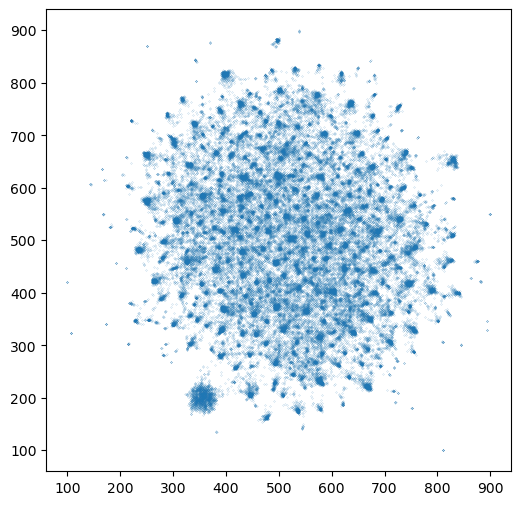

In [69]:
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df_processing["x"], df_processing["y"], s=0.01)

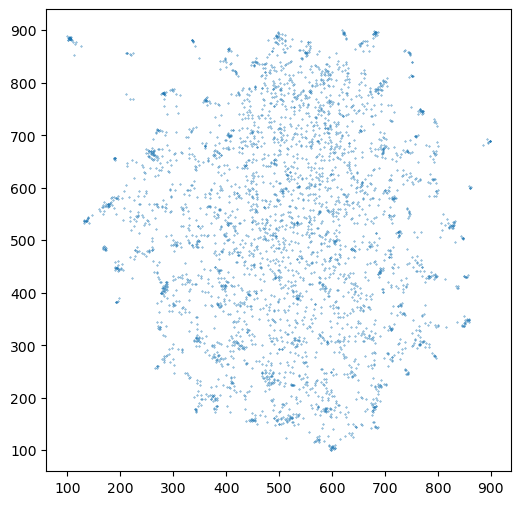

In [70]:
plt.figure(figsize=(6, 6), dpi=100)  
plt.scatter(df_cinder["x"], df_cinder["y"], s=0.1)

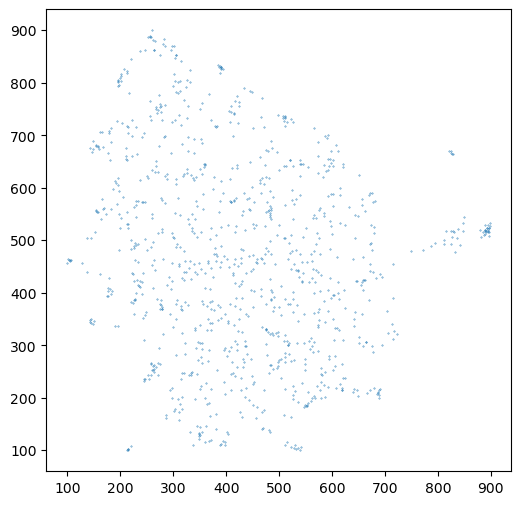

In [71]:
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df_openrndr["x"], df_openrndr["y"], s=0.1)

### Clustering - HDBSCAN

In [72]:
def apply_hdbscan(df, min_cluster_size=30, min_samples=5, cluster_selection_epsilon=0.2, cluster_selection_method='leaf'):
    # initializing 'cluster' column
    df['cluster'] = '-1' 

    # defining hdbscan parameters
    hdbscan_params = {
        'min_cluster_size': min_cluster_size, # minimum number of points to form a cluster
        'min_samples': min_samples, # higher = fewer, more distinct clusters
        'cluster_selection_epsilon': cluster_selection_epsilon, # allows small variation to be grouped into larger clusters, higher = fewer clusters
        # 'metric': 'haversine',
        'cluster_selection_method': cluster_selection_method 
    }

    # define conditions and prefixes, if any

    # with umap embeddings
    embedding = df[['x', 'y']].to_numpy()  
    
    # perform clustering and assing labels
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(embedding)

    return clusterer, labels

In [94]:
#clusterer_processing, labels_processing = apply_hdbscan(df_processing, min_cluster_size=70, min_samples=40, cluster_selection_epsilon=0.7)
clusterer_cinder, labels_cinder = apply_hdbscan(df_cinder, min_cluster_size=40, min_samples=20, cluster_selection_epsilon=0.5)
clusterer_openrndr, labels_openrndr = apply_hdbscan(df_openrndr)

clusterer_processing, labels_processing = apply_hdbscan(df_processing, min_cluster_size=500, min_samples=40, cluster_selection_epsilon=0.7)

In [95]:
df_processing['cluster'] = labels_processing
df_cinder['cluster'] = labels_cinder
df_openrndr['cluster'] = labels_openrndr 

In [96]:
df_processing['cluster'].nunique()

48

In [97]:
df_cinder['cluster'].value_counts()

cluster
-1     2415
 17     126
 14     100
 16      92
 6       88
 15      81
 8       71
 3       69
 0       66
 4       55
 11      51
 12      50
 7       50
 9       49
 13      49
 1       45
 2       44
 10      44
 5       41
Name: count, dtype: int64

In [98]:
df_processing['cluster'].value_counts()

cluster
-1     38478
 33     2429
 0      1690
 45     1425
 35     1217
 32     1045
 25     1044
 22     1043
 26     1039
 28     1036
 19     1018
 31     1009
 15      995
 23      937
 41      917
 2       895
 11      850
 10      776
 38      762
 20      761
 27      735
 16      732
 46      718
 39      708
 17      707
 24      667
 6       662
 18      655
 14      655
 42      650
 36      644
 8       641
 40      620
 34      617
 37      601
 12      597
 21      593
 1       592
 5       582
 4       574
 9       571
 3       563
 29      561
 44      560
 13      539
 30      518
 43      514
 7       502
Name: count, dtype: int64

In [99]:
df_cinder['cluster'].nunique()

19

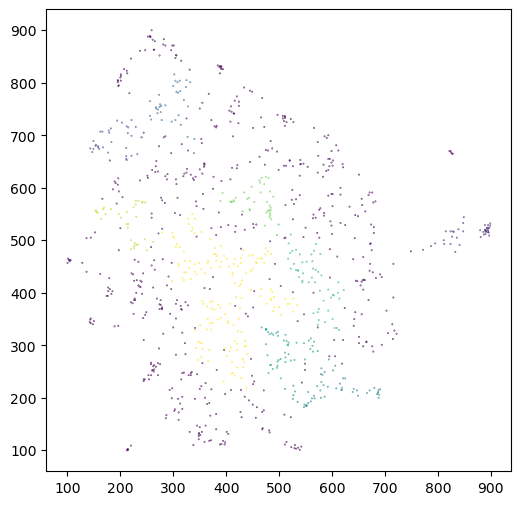

In [100]:
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df_openrndr["x"], df_openrndr["y"], s=0.1, c=df_openrndr['cluster'])

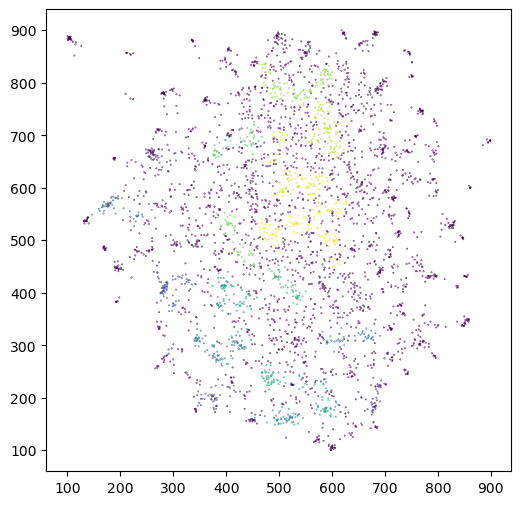

In [101]:
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df_cinder["x"], df_cinder["y"], s=0.1, c=df_cinder['cluster'])

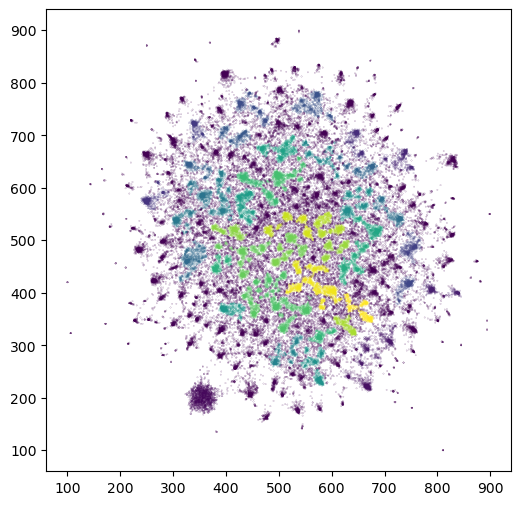

In [102]:
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df_processing["x"], df_processing["y"], s=0.01, c=df_processing['cluster'])

/var/folders/g5/d9_b48zx673cq3r2_9nwfb4m0000gn/T/ipykernel_63578/496367296.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_c = plt.cm.get_cmap('tab20', len(unique_labels_c))  # 'viridis', 'plasma'


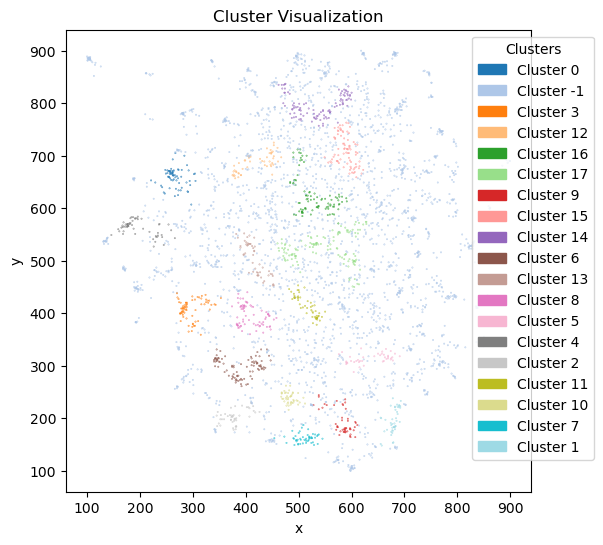

In [103]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Get unique cluster labels
unique_labels_c = df_cinder['cluster'].unique()

# Generate a colormap with a unique color for each cluster
colormap_c = plt.cm.get_cmap('tab20', len(unique_labels_c))  # 'viridis', 'plasma'

# Map each cluster to a color
color_mapping_c = {label: colormap_c(i) for i, label in enumerate(unique_labels_c)}
colors_c = df_cinder['cluster'].map(color_mapping_c)

# Plot the scatter plot
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(
    df_cinder["x"], 
    df_cinder["y"], 
    s=0.1, 
    c=colors_c
)

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color_mapping_c[label], label=f'Cluster {label}')
    for label in unique_labels_c
]

# Add legend
plt.legend(handles=legend_handles, title="Clusters", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.title("Cluster Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/var/folders/g5/d9_b48zx673cq3r2_9nwfb4m0000gn/T/ipykernel_63578/3710168425.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_labels_o))  # 'viridis', 'plasma'


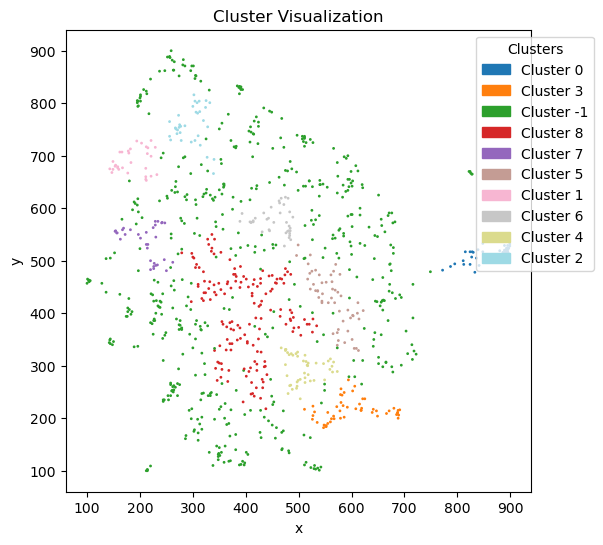

In [104]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Get unique cluster labels
unique_labels_o = df_openrndr['cluster'].unique()

# Generate a colormap with a unique color for each cluster
colormap = plt.cm.get_cmap('tab20', len(unique_labels_o))  # 'viridis', 'plasma'

# Map each cluster to a color
color_mapping_o = {label: colormap(i) for i, label in enumerate(unique_labels_o)}
colors_o = df_openrndr['cluster'].map(color_mapping_o)

# Plot the scatter plot
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(
    df_openrndr["x"], 
    df_openrndr["y"], 
    s=1, 
    c=colors_o
)

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color_mapping_o[label], label=f'Cluster {label}')
    for label in unique_labels_o
]

# Add legend
plt.legend(handles=legend_handles, title="Clusters", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.title("Cluster Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/var/folders/g5/d9_b48zx673cq3r2_9nwfb4m0000gn/T/ipykernel_63578/1643767777.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_p = plt.cm.get_cmap('tab20', len(unique_labels_p))  # 'viridis', 'plasma'


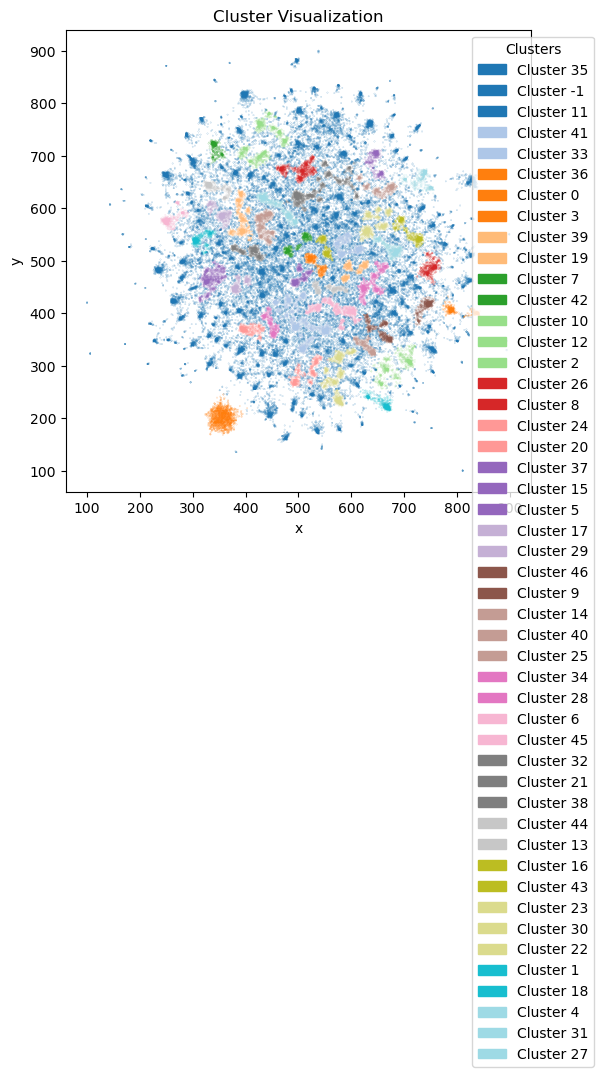

In [105]:
# Get unique cluster labels
unique_labels_p = df_processing['cluster'].unique()

# Generate a colormap with a unique color for each cluster
colormap_p = plt.cm.get_cmap('tab20', len(unique_labels_p))  # 'viridis', 'plasma'

# Map each cluster to a color
color_mapping_p = {label: colormap_p(i) for i, label in enumerate(unique_labels_p)}
colors_p = df_processing['cluster'].map(color_mapping_p)

# Plot the scatter plot
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(
    df_processing["x"], 
    df_processing["y"], 
    s=0.01, 
    c=colors_p
)

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color_mapping_p[label], label=f'Cluster {label}')
    for label in unique_labels_p
]

# Add legend
plt.legend(handles=legend_handles, title="Clusters", loc="upper right", bbox_to_anchor=(1.15, 1))

plt.title("Cluster Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### extract keywords per cluster

In [106]:
def extract_keywords(df, column='cluster', top_n=25, max_features=1000):
    results = []

    for cluster_id, group in df.groupby(column):
        # vectorizing the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group['lemmas'] = group['lemmas'].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )

        # print(group["lemmas"])
        # print(test)
        # print(" ".join(group['lemmas']))
        
        X = vectorizer.fit_transform(lemmas)

        # calculating word frequencies
        word_sums = X.sum(axis=0).A1  # converting matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)

# error some documents may only contain stop words, trying another method below:

In [107]:
keywords_processing = extract_keywords(df_processing)
keywords_cinder = extract_keywords(df_cinder)
keywords_openrndr = extract_keywords(df_openrndr)

In [109]:
keywords_cinder

,cluster,top_keywords
0,-1,"[app, project, issue, error, time, sample, ver..."
1,0,"[video, player, windows, playback, project, li..."
2,1,"[particle, mesh, shader, position, vbo, gpu, s..."
3,2,"[fbo, texture, screen, sample, object, circle,..."
4,3,"[window, function, context, app, fbo, method, ..."
5,4,"[device, output, audio, input, touch, channel,..."
6,5,"[text, object, obj, animation, block, function..."
7,6,"[image, color, alpha, value, channel, texture,..."
8,7,"[shader, fragment, vertex, texture, glsl, cpu,..."
9,8,"[thread, texture, screen, surface, thing, cont..."


In [110]:
keywords_openrndr

,cluster,top_keywords
0,-1,"[shader, video, issue, time, line, version, co..."
1,0,"[graphic, nvidia, card, intel, amd, driver, gp..."
2,1,"[triangle, buffer, vertex, edge, color, render..."
3,2,"[shape, import, contour, point, circle, functi..."
4,3,"[project, template, error, idea, version, grad..."
5,4,"[kotlin, library, version, language, time, jav..."
6,5,"[feature, forum, thread, discourse, cheer, ps,..."
7,6,"[function, change, class, package, olive, upda..."
8,7,"[effect, value, curve, range, line, design, re..."
9,8,"[image, time, case, solution, thing, kotlin, i..."


In [111]:
keywords_processing

,cluster,top_keywords
0,-1,"[time, problem, class, value, error, datum, qu..."
1,0,"[fish, aquarium, circley, bug, reason, place, ..."
2,1,"[solution, problem, idea, method, thing, point..."
3,2,"[game, input, application, screen, enemy, time..."
4,3,"[link, source, error, time, problem, reference..."
5,4,"[int, question, answer, array, setup, value, s..."
6,5,"[answer, command, solution, help, problem, pro..."
7,6,"[error, problem, polygon, point, issue, progra..."
8,7,"[lot, time, thing, work, problem, idea, script..."
9,8,"[string, array, number, text, method, value, e..."


In [112]:
df_processing = df_processing.merge(keywords_processing, on='cluster', how='left')
df_cinder = df_cinder.merge(keywords_cinder, on='cluster', how='left')
df_openrndr = df_openrndr.merge(keywords_openrndr, on='cluster', how='left')
# export to csv and use as input for LLM representation notebook

### LLM representation
refer to notebook ''

In [125]:
# dataframes after cluster labeling with llm (llama2)
df_processing_ = pd.read_csv('df_processing_.csv')
df_cinder_ = pd.read_csv('df_cinder_.csv')
df_openrndr_ = pd.read_csv('df_openrndr_.csv')

### User-based Insights

In [129]:
df_processing_user = processing[['id', 'reply_count', 'reply_to_post_number', 'reply_to_user', 'reads', 'score', 'moderator', 'admin', 'staff', 'trust_level', 'link_counts']].copy()
df_cinder_user = cinder[['id', 'reply_count', 'reply_to_post_number', 'reply_to_user', 'reads', 'score', 'moderator', 'admin', 'staff', 'trust_level', 'link_counts']].copy()
df_openrndr_user = openrndr[['id', 'reply_count', 'reply_to_post_number', 'reply_to_user', 'reads', 'score', 'moderator', 'admin', 'staff', 'trust_level']].copy()

# replies = post_number, reply_count, reply_to_post_number | per user = reply_to_user, user_id
# reads = reads/readers_count (i think same numbers)  
# score -- not sure how this is calculated though
# topics = topic_id, topic_slug
# user position = moderator, admin, staff, trust_level
# top links = link_counts

In [130]:
df_processing_merged = pd.merge(df_processing_, df_processing_user, on='id')
df_cinder_merged = pd.merge(df_cinder_, df_cinder_user, on='id')
df_openrndr_merged = pd.merge(df_openrndr_, df_openrndr_user, on='id')

cluster -level analysis of user behavior

In [131]:
df_processing_merged.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'created_at', 'cooked',
       'post_number', 'post_type', 'topic_id', 'topic_slug', 'user_id', 'year',
       'code_content', 'a_content', 'cooked_cleaned', 'cooked_html_cleaned',
       'word_count', 'combined', 'parsing', 'lemmas', 'x', 'y', 'cluster',
       'top_keywords', 'cluster_label', 'reply_count', 'reply_to_post_number',
       'reply_to_user', 'reads', 'score', 'moderator', 'admin', 'staff',
       'trust_level', 'link_counts'],
      dtype='object')

In [142]:
# Add user role distribution
def get_user_roles(df, groupby_col='cluster_label'):
    role_dist = (
        df.groupby([groupby_col, 'trust_level'])
        .size()
        .reset_index(name='count')
    )

    # normalixe role counts to percentages wihtin each cluster
    role_dist['percentage'] = (
        role_dist.groupby(groupby_col)['count']
        .transform(lambda x: x / x.sum() * 100)
    )

    # user roles: moderator, staff, admin
    user_roles = ['moderator', 'staff', 'admin']
    role_summary = (
        df.groupby(groupby_col)[user_roles]
        .sum()
        .reset_index()
    )

    final_roles = pd.merge(role_dist, role_summary, on=groupby_col, how='left')

    return final_roles

In [143]:
user_roles_processing = get_user_roles(df_processing_merged)
user_roles_cinder = get_user_roles(df_cinder_merged)
user_roles_openrndr = get_user_roles(df_openrndr_merged)

In [160]:
def plot_combined_metrics(cluster_metrics, role_dist, metrics=['avg_replies', 'avg_reads', 'avg_score']):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot aggregated metrics
    cluster_metrics.plot(
        x='cluster_label',
        y=metrics,
        kind='bar',
        ax=axes[0],
        alpha=0.8,
        colormap='Set1'
    )
    axes[0].set_title('Aggregated Metrics by Cluster')
    axes[0].set_xlabel('Cluster Label')
    axes[0].set_ylabel(f'Average Value - {metrics}')
    axes[0].legend(metrics)

    # Plot role distribution
    pivot_table = role_dist.pivot(index='cluster_label', columns='trust_level', values='percentage').fillna(0)
    pivot_table.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        colormap='Set2',
        alpha=0.85
    )
    axes[1].set_title('Role Distribution by Cluster (Trust Levels)')
    axes[1].set_xlabel('Cluster Label')
    axes[1].set_ylabel('Percentage')
    axes[1].legend(title='Trust Level')

    plt.tight_layout()
    plt.show()


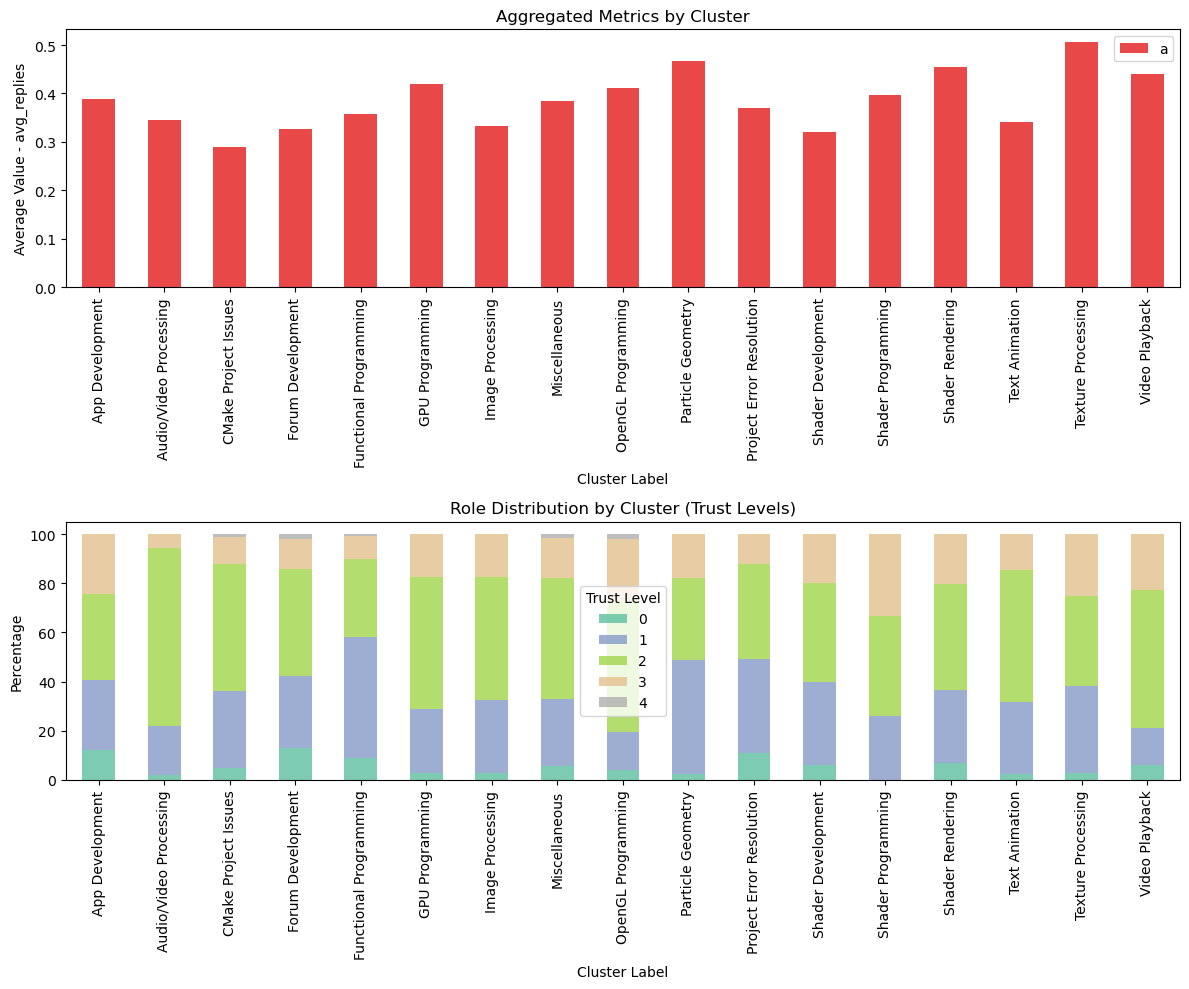

In [161]:
plot_combined_metrics(cluster_usermetrics_cinder, user_roles_cinder, metrics='avg_replies')

user participation in topics, user interaction

In [171]:
def user_participation_in_clusters(df, groupby_col='cluster_label'):
    user_participation = df.groupby(['user_id', groupby_col]).size().reset_index(name='contributions')

    # Identify power users (users who dominate a cluster)
    power_users = user_participation.groupby(groupby_col).apply(
        lambda x: x.loc[x['contributions'] == x['contributions'].max()]
    ).reset_index(drop=True)

    return user_participation, power_users

In [174]:
power_users_cinder

,user_id,cluster_label,contributions
0,14,App Development,7
1,13,Audio/Video Processing,9
2,19,CMake Project Issues,10
3,31,CMake Project Issues,10
4,14,Forum Development,9
5,31,Functional Programming,8
6,44,GPU Programming,14
7,14,Image Processing,18
8,14,Miscellaneous,226
9,31,OpenGL Programming,10


In [244]:
# calculate topic engagement
def calc_topic_engagement(df, cluster_col='cluster_label'):
    topic_engagement = (
        df.groupby(cluster_col).agg(
            total_replies = ('reply_count', 'sum'),
            total_reads = ('reads', 'sum'),
            avg_replies = ('reply_count', 'mean'),
            avg_reads = ('reads', 'mean'),
            total_posts = ('id', 'count'),
            unique_users = ('user_id', 'nunique'),
        ).reset_index()
    )
    return topic_engagement

In [245]:
def id_engagement_levels(topic_engagement, metric='total_replies', threshold=0.8):
    # determine high and low engagement clusters using a threshold (e.g. top 20%)
    high_threshold = topic_engagement[metric].quantile(threshold)
    low_threshold = topic_engagement[metric].quantile(1-threshold)

    topic_engagement['engagement_level'] = topic_engagement[metric].apply(
        lambda x: 'High' if x >= high_threshold else 'Low' if x <= low_threshold else 'Medium'
    )
    return topic_engagement

In [246]:
topic_engagement_processing = calc_topic_engagement(df_processing_merged)
topic_engagement_processing = id_engagement_levels(topic_engagement_processing)

topic_engagement_cinder = calc_topic_engagement(df_cinder_merged)
topic_engagement_cinder = id_engagement_levels(topic_engagement_cinder)

topic_engagement_openrndr = calc_topic_engagement(df_openrndr_merged)
topic_engagement_openrndr = id_engagement_levels(topic_engagement_openrndr)

In [247]:
topic_engagement_processing

,cluster_label,total_replies,total_reads,avg_replies,avg_reads,total_posts,unique_users,engagement_level
0,Android App Development,391,18754,0.376323,18.050048,1039,377,Medium
1,Animation Frame Rate,291,10306,0.471637,16.703404,617,284,Medium
2,Aquarium Programming,734,27236,0.434320,16.115976,1690,778,High
3,Arduino Programming,345,11748,0.452756,15.417323,762,305,Medium
4,Array Method Problem,314,9737,0.506452,15.704839,620,284,Medium
5,Circle Problem,341,13373,0.463946,18.194558,735,372,Medium
6,Class Object,458,15319,0.488794,16.348986,937,369,Medium
7,Code Issues,236,9229,0.413310,16.162872,571,339,Low
8,Coding Help,252,10851,0.447602,19.273535,563,284,Low
9,Color and Shape,608,25269,0.426667,17.732632,1425,573,High


In [248]:
topic_engagement_processing.to_csv('cluster_stats_processing.csv')
topic_engagement_cinder.to_csv('cluster_stats_cinder.csv')
topic_engagement_openrndr.to_csv('cluster_stats_openrndr.csv')

In [205]:
def plot_topic_engagement(topic_engagement, exclude_clusters=None):
    # Convert cluster_label to string if not already
    topic_engagement['cluster_label'] = topic_engagement['cluster_label'].astype(str)

    # Exclude specified clusters if provided
    if exclude_clusters:
        topic_engagement = topic_engagement[~topic_engagement['cluster_label'].isin(exclude_clusters)]

    # Sort the data by total_replies for better visualization
    topic_engagement = topic_engagement.sort_values(by='total_replies', ascending=False)
    cluster_labels = topic_engagement['cluster_label']

    fig, axes = plt.subplots(4, 1, figsize=(12, 20))  # Create 4 subplots

    # Plot total replies
    axes[0].bar(cluster_labels, topic_engagement['total_replies'], color='skyblue')
    axes[0].set_title('Total Replies by Cluster')
    axes[0].set_ylabel('Total Replies')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot total reads
    axes[1].bar(cluster_labels, topic_engagement['total_reads'], color='lightgreen')
    axes[1].set_title('Total Reads by Cluster')
    axes[1].set_ylabel('Total Reads')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot total posts
    axes[2].bar(cluster_labels, topic_engagement['total_posts'], color='coral')
    axes[2].set_title('Total Posts by Cluster')
    axes[2].set_ylabel('Total Posts')
    axes[2].tick_params(axis='x', rotation=45)

    # Plot engagement levels as a count plot
    sns.countplot(
        x='engagement_level',
        data=topic_engagement,
        order=['High', 'Medium', 'Low'],
        palette='muted',
        ax=axes[3],
    )
    axes[3].set_title('Engagement Levels')
    axes[3].set_xlabel('Engagement Level')
    axes[3].set_ylabel('Cluster Count')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


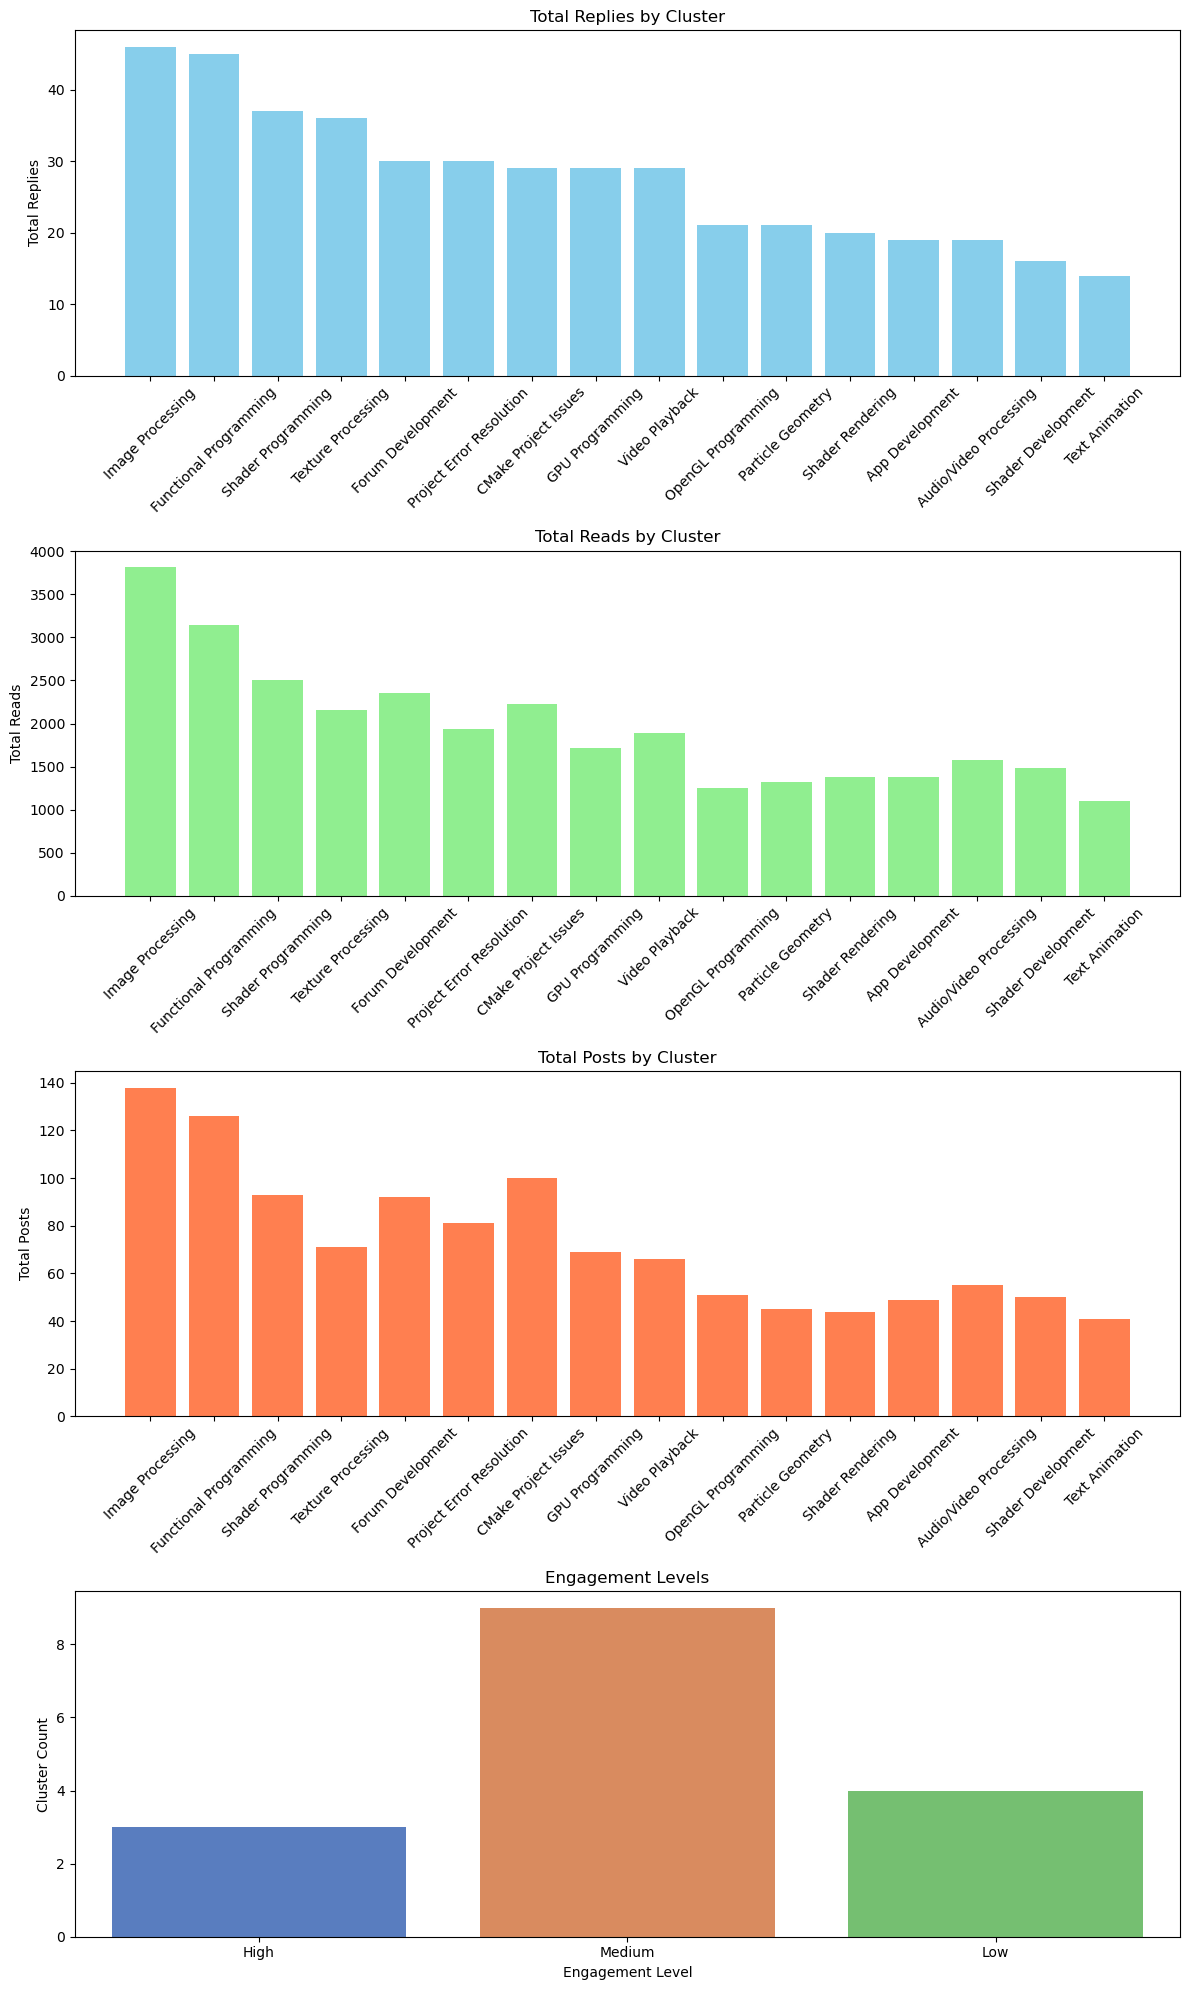

In [206]:
plot_topic_engagement(topic_engagement_cinder, exclude_clusters=['Miscellaneous'])

cleaning cooked for display in the final visualisation output

In [236]:
def clean_to_display(html):
    non_text_tags = {'svg', 'use', 'path', 'img', 'video', 'source', 'iframe'}

    # Parse the HTML content
    soup = BeautifulSoup(html, "html.parser")
    
    # Remove non-textual tags
    for tag in non_text_tags:
        for element in soup.find_all(tag):
            element.decompose()  # Removes the element completely

    # Replace <code> tags with 'code content'
    for code in soup.find_all("code"):
        code.replace_with('<code content>')  # Replace <code> content with a placeholder

    # Remove mentions (e.g., <a class="mention" href="/u/username">)
    for mention in soup.find_all("a", class_="mention"):
        mention.decompose()

    # Remove quotes if they might contain usernames
    for quote in soup.find_all("aside", class_="quote"):
        quote.decompose()

    # Optionally remove other attributes like "data-username"
    for tag_with_user in soup.find_all(attrs={"data-username": True}):
        tag_with_user.decompose()
    
    # Remove email addresses or user-like patterns using regex
    clean_text = str(soup)
    clean_text = re.sub(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', '', clean_text)  # Remove emails
    clean_text = re.sub(r'@\w+', '', clean_text)  # Remove @usernames (Twitter-like mentions)
    clean_text = re.sub(r'\s+', ' ', clean_text)  # Remove extra whitespaces 

    # Remove any remaining HTML tags
    clean_text = BeautifulSoup(clean_text, "html.parser").get_text()

    # Extract the remaining content as plain text
    return clean_text.strip()

In [237]:
# Apply the cleaning function to your DataFrame
df_processing_merged['cooked_to_display'] = df_processing_merged['cooked'].apply(clean_to_display)
df_cinder_merged['cooked_to_display'] = df_cinder_merged['cooked'].apply(clean_to_display)
df_openrndr_merged['cooked_to_display'] = df_openrndr_merged['cooked'].apply(clean_to_display)

In [240]:
df_processing_merged.to_json('df_processing_merged.json', orient='records')
df_cinder_merged.to_json('df_cinder_merged.json', orient='records')
df_openrndr_merged.to_json('df_openrndr_merged.json', orient='records')